# Chapter 04 패션 아이템을 구분하는 DNN

## 4.1 Fashion MNIST 데이터셋

train : 28x28의 데이터 70000개 </br>
target : 10가지 카테고리

In [3]:
# 모듈 import
from torchvision import datasets, transforms, utils
from torch.utils import data

In [4]:
import matplotlib.pyplot as plt
import numpy as np

데이터 변환 함수

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
# data load
trainset = datasets.FashionMNIST(
    root = './',
    train = True,
    download = True,
    transform = transform
)

testset = datasets.FashionMNIST(
    root = './',
    train = False,
    download = True,
    transform = transform
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



DataLoader느 데이터셋을 배치로 쪼개고 학습 시 반복문 안에서 데이터를 공급해주는 클래스

In [8]:
from torch.utils.data import dataset
batch_size = 16

train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = batch_size
)

test_loader = data.DataLoader(
    dataset = testset,
    batch_size = batch_size
)

In [11]:
# 배치 하나 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [12]:
img = utils.make_grid(images, padding=0)
img.size()

torch.Size([3, 56, 224])

In [13]:
images.size()

torch.Size([16, 1, 28, 28])

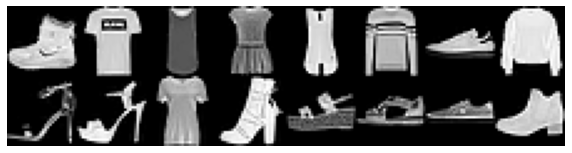

In [15]:
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.axis('off')
plt.show()

In [17]:
print(labels)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


In [18]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [20]:
for label in labels:
    index = label.item()
    print(CLASSES[index])

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot


In [21]:
idx = 1
item_img = images[idx]

In [23]:
item_img.squeeze().size()

torch.Size([28, 28])

In [24]:
item_npimg = item_img.squeeze().numpy()

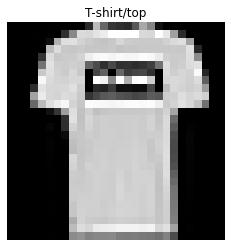

In [26]:
plt.title(CLASSES[labels[idx].item()])
plt.imshow(item_npimg, cmap='gray')
plt.axis('off')
plt.show()

전체 코드 및 연습

In [27]:
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기 및 전처리
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = datasets.FashionMNIST(
    root = './',
    train = True,
    download = True,
    transform = transform
)

testset = datasets.FashionMNIST(
    root = './',
    train = False,
    download = False,
    transform = transform
)

batch_size = 16
train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = batch_size
)

test_loader = data.DataLoader(
    dataset = testset,
    batch_size = batch_size
)

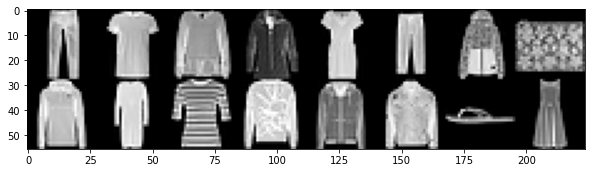

In [28]:
dataiter = iter(train_loader)
next(dataiter)

images, labels = next(dataiter)

img = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [30]:
for label in labels:
    index = label.item()
    print(CLASSES[index], end=', ')

Trouser, T-shirt/top, Shirt, Coat, Dress, Trouser, Coat, Bag, Coat, Dress, T-shirt/top, Pullover, Coat, Coat, Sandal, Dress, 

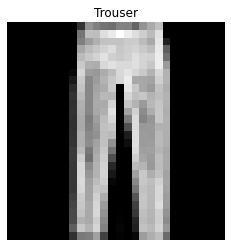

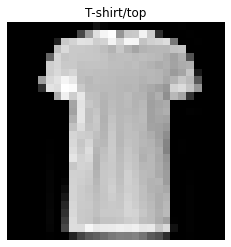

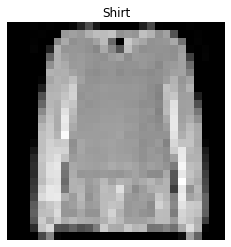

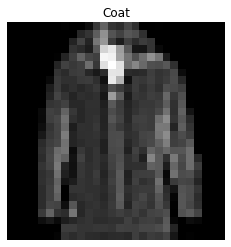

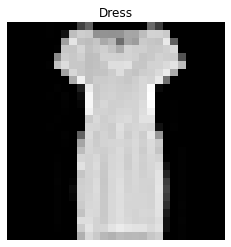

In [32]:
for i in range(5):
    item_img = images[i]
    item_npimg = item_img.squeeze().numpy()
    plt.title(CLASSES[labels[i].item()])
    plt.imshow(item_npimg, cmap='gray')
    plt.axis('off')
    plt.show()